In [1]:
import numpy as np
import matplotlib.pyplot as plt

from DOE import *
from active_learning import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
X, Y = ReadExercise1("ex1_data.csv")
cv_metrics = ['neg_mean_absolute_error']
save = True

Design of Experiments

In [3]:
error_log = []
for i in range(30):
    seed = 2024*i
    doe_score, doe_idxs = DOE(X,Y, k=30, seed=seed, threshold= 1e-8, cap=5000, metric=D_optimal)
    mask = np.ones(X.shape[0])
    mask[doe_idxs] = False
    mask = np.array(mask, dtype=bool)

    train_x, train_y = X[doe_idxs], Y[doe_idxs]
    test_x, test_y = X[mask], Y[mask]
    
    clf = LinearRegression()
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    error_log.append(mean_squared_error(test_y,y_pred))

if save:
    np.save("results/doe_mse.npy", error_log)

Active Learning with Uncertainty Sampling

In [4]:
logs = []
for i in range(30):
    clf = LinearRegression()
    res = SimulateAL_MP(X,Y,method='US',seed=i*2024,clf = clf,cv_metrics=cv_metrics,init_frac=0.1,end_frac=0.3,logging_func=TestLog)
    res = [ele[0] for ele in res]
    logs.append(res)
mse_log = []
for log in logs:
    mse_log.append(log[-1])
mse_log = np.array(mse_log)

if save:
    np.save("results/us_mse.npy", mse_log)

Passive Learning

In [5]:
logs = []
for i in range(30):
    clf = LinearRegression()
    res = SimulateAL_MP(X,Y,method='rand',seed=i*2024,clf = clf,cv_metrics=cv_metrics,init_frac=0.1,end_frac=0.3,logging_func=TestLog)
    res = [ele[0] for ele in res]
    logs.append(res)
mse_log = []
for log in logs:
    mse_log.append(log[-1])
mse_log = np.array(mse_log)

if save:
    np.save("results/pl_mse.npy", mse_log)


In [4]:
def PlotData(filepaths,xtick_names):
    weights = []
    errors = []
    for path in filepaths:
        data = np.load(f'results/{path}')
        weights.append(np.mean(data))
        errors.append(np.std(data))

    fig, ax = plt.subplots(1)
    ax.bar(range(3), weights)    
    ax.errorbar(range(3), weights, errors, color = 'r', linestyle = '', capsize=5)
    ax.set_xticks(range(3), xtick_names)
    return fig, ax

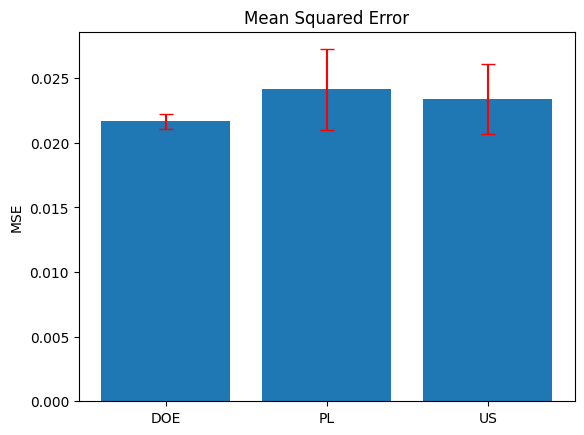

In [5]:
filenames = ['doe_mse.npy','pl_mse.npy', 'us_mse.npy']
xtick_names = ['DOE', 'PL', 'US']
fig, ax = PlotData(filenames, xtick_names)
ax.set_title('Mean Squared Error')
ax.set_ylabel('MSE')
plt.show(fig)

# PART 2 Of Question 1

DOE combined with Active Learning

In [3]:
logs = []
for i in range(10):
    clf = LinearRegression()
    res = SimulateAL_MP(X,Y,method='US',seed=i*2024,clf=clf,cv_metrics=cv_metrics,init_method='DOE',init_frac=0.1,end_frac=0.5,logging_func=TestLog)
    res = [ele[0] for ele in res]
    logs.append(res)
mse_log = np.array(logs)
if save:
    np.save('results/doe_us.npy', mse_log)

In [4]:
logs = []
for i in range(10):
    clf = LinearRegression()
    res = SimulateAL_MP(X,Y,method='US',seed=i*2024,clf=clf,cv_metrics=cv_metrics,init_method=None,init_frac=0.1,end_frac=0.5,logging_func=TestLog)
    res = [ele[0] for ele in res]
    logs.append(res)
mse_log = np.array(logs)
if save:
    np.save('results/rand_us.npy', mse_log)

In [4]:
def PlotData(filepaths, labels):
    fig, ax = plt.subplots(1)
    mse = []
    errors = []
    for path in filepaths:
        data = np.load(f"results/{path}")
        mse.append(np.mean(data, axis=0))
        errors.append(np.std(data, axis=0))
    
    for data, err, label in zip(mse, errors, labels):
        handle, = ax.plot(range(10, data.shape[0]+10), data, label = label)
        color = handle.get_color()
        ax.errorbar(range(10, data.shape[0]+10), data, err, color = color, linestyle = '', capsize=5, alpha = 0.2)
        ax.legend()

    return fig, ax
    

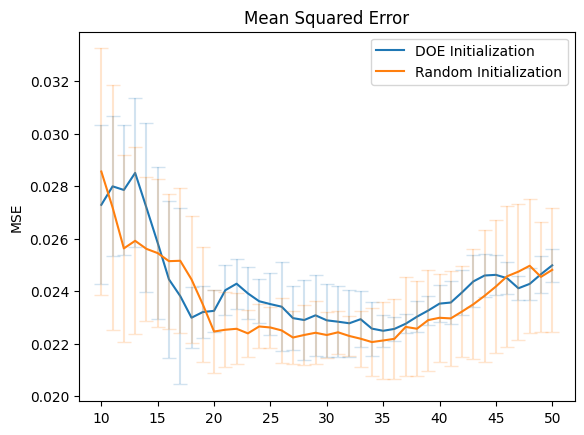

In [5]:
filepaths = ['doe_us.npy', 'rand_us.npy']
labels = 'DOE Initialization', 'Random Initialization'
fig, ax = PlotData(filepaths, labels)
ax.set_title('Mean Squared Error')
ax.set_ylabel('MSE')
plt.show(fig)